In [1]:
# grab directory root
import sys
sys.path.append("../")

In [2]:
from dinov3.eval.tSNE import compute_tsne_and_plot, extract_embeddings, evaluate_knn_faiss
from dinov3.data.datasets import NCells
from dinov3.models.backbone_loader import load_backbone
import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

/home/students/.conda/envs/sai/lib/python3.10/site-packages/torch/distributed/distributed_c10d.py:4807: UserWarning: No device id is provided via `init_process_group` or `barrier `. Using the current device set by the user. 
  warnings.warn(  # warn only once
[rank0]:[W827 16:04:37.650999628 ProcessGroupNCCL.cpp:5023] [PG ID 0 PG GUID 0 Rank 0]  using GPU 0 as device used by this process is currently unknown. This can potentially cause a hang if this rank to GPU mapping is incorrect. You can specify device_id in init_process_group() to force use of a particular device.


In [3]:
from torchvision import transforms

# defaul transform used in dinv3
def make_transform(resize_size: int | list[int] = 768):
    to_tensor = transforms.ToTensor()
    resize = transforms.Resize((resize_size, resize_size), antialias=True)
    normalize = transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
    )
    return transforms.Compose([to_tensor, resize, normalize])

dataset = NCells(
    root="/home/students/code/helmholtzSS25/Hannes/dinov3playground/manifest_train_fixed.csv.gz",
    split=NCells.Split.TRAIN,
    transform=make_transform(), 
    target_transform=None,
)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])

In [4]:
model = load_backbone(
    config_file="/home/students/code/helmholtzSS25/sai/dinov3playground/outputs-tripletv1/config.yaml",
    pretrained_weights="/home/students/code/helmholtzSS25/sai/dinov3playground/outputs-tripletv1/ckpt/123749",
    output_dir="/home/students/code/helmholtzSS25/sai/dinov3playground/outputs-tripletv1"
)

Materializing model parameters on cuda
Model loaded on 123750 start iteration
Model backbone architecture: 
 DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (rope_embed): RopePositionEmbedding()
  (blocks): ModuleList(
    (0-11): 12 x SelfAttentionBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): SelfAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        

In [5]:
target_size = 224
batch_size = 64
num_workers = 6
embeddings, labels = extract_embeddings(
    model=model,
    dataset=test_dataset,
    device=DEVICE,
    batch_size=batch_size,
    num_workers=num_workers,
    target_size=target_size,
)

Starting embedding extraction. Batches: 6725


batches: 100%|██████████| 6725/6725 [12:02<00:00,  9.30it/s]


In [6]:
set(labels)

{'Adrenal_gland__Connective',
 'Adrenal_gland__Epithelial',
 'Adrenal_gland__Inflammatory',
 'Adrenal_gland__Neoplastic',
 'Big',
 'Bile-duct__Connective',
 'Bile-duct__Epithelial',
 'Bile-duct__Inflammatory',
 'Bile-duct__Neoplastic',
 'Bladder__Connective',
 'Bladder__Inflammatory',
 'Bladder__Neoplastic',
 'Breast__Connective',
 'Breast__Dead',
 'Breast__Epithelial',
 'Breast__Inflammatory',
 'Breast__Neoplastic',
 'CD20',
 'CD3',
 'CD34',
 'CD38',
 'CD68',
 'CDK4',
 'Cell',
 'Cervix__Connective',
 'Cervix__Dead',
 'Cervix__Epithelial',
 'Cervix__Inflammatory',
 'Cervix__Neoplastic',
 'Colon__Connective',
 'Colon__Dead',
 'Colon__Epithelial',
 'Colon__Inflammatory',
 'Colon__Neoplastic',
 'Control__B',
 'Control__DC',
 'Control__M0',
 'Control__Negs',
 'Control__Nk',
 'Control__T0',
 'Control__T4',
 'Control__T8',
 'D2',
 'Debris',
 'DyingCell',
 'Epithelial',
 'Esophagus__Connective',
 'Esophagus__Dead',
 'Esophagus__Epithelial',
 'Esophagus__Inflammatory',
 'Esophagus__Neoplastic'

/home/students/code/helmholtzSS25/sai/dinov3playground/notebooks/../dinov3/eval/tSNE.py:239: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


Saved TSNE to tsne_test_split.png


array([[-82.409355 ,  45.646156 ],
       [ 10.2779665,  32.039288 ],
       [-91.51825  ,  27.733698 ],
       ...,
       [  5.3284883,  45.92537  ],
       [-77.4134   , -20.365294 ],
       [ 38.9848   , -73.44523  ]], shape=(430351, 2), dtype=float32)

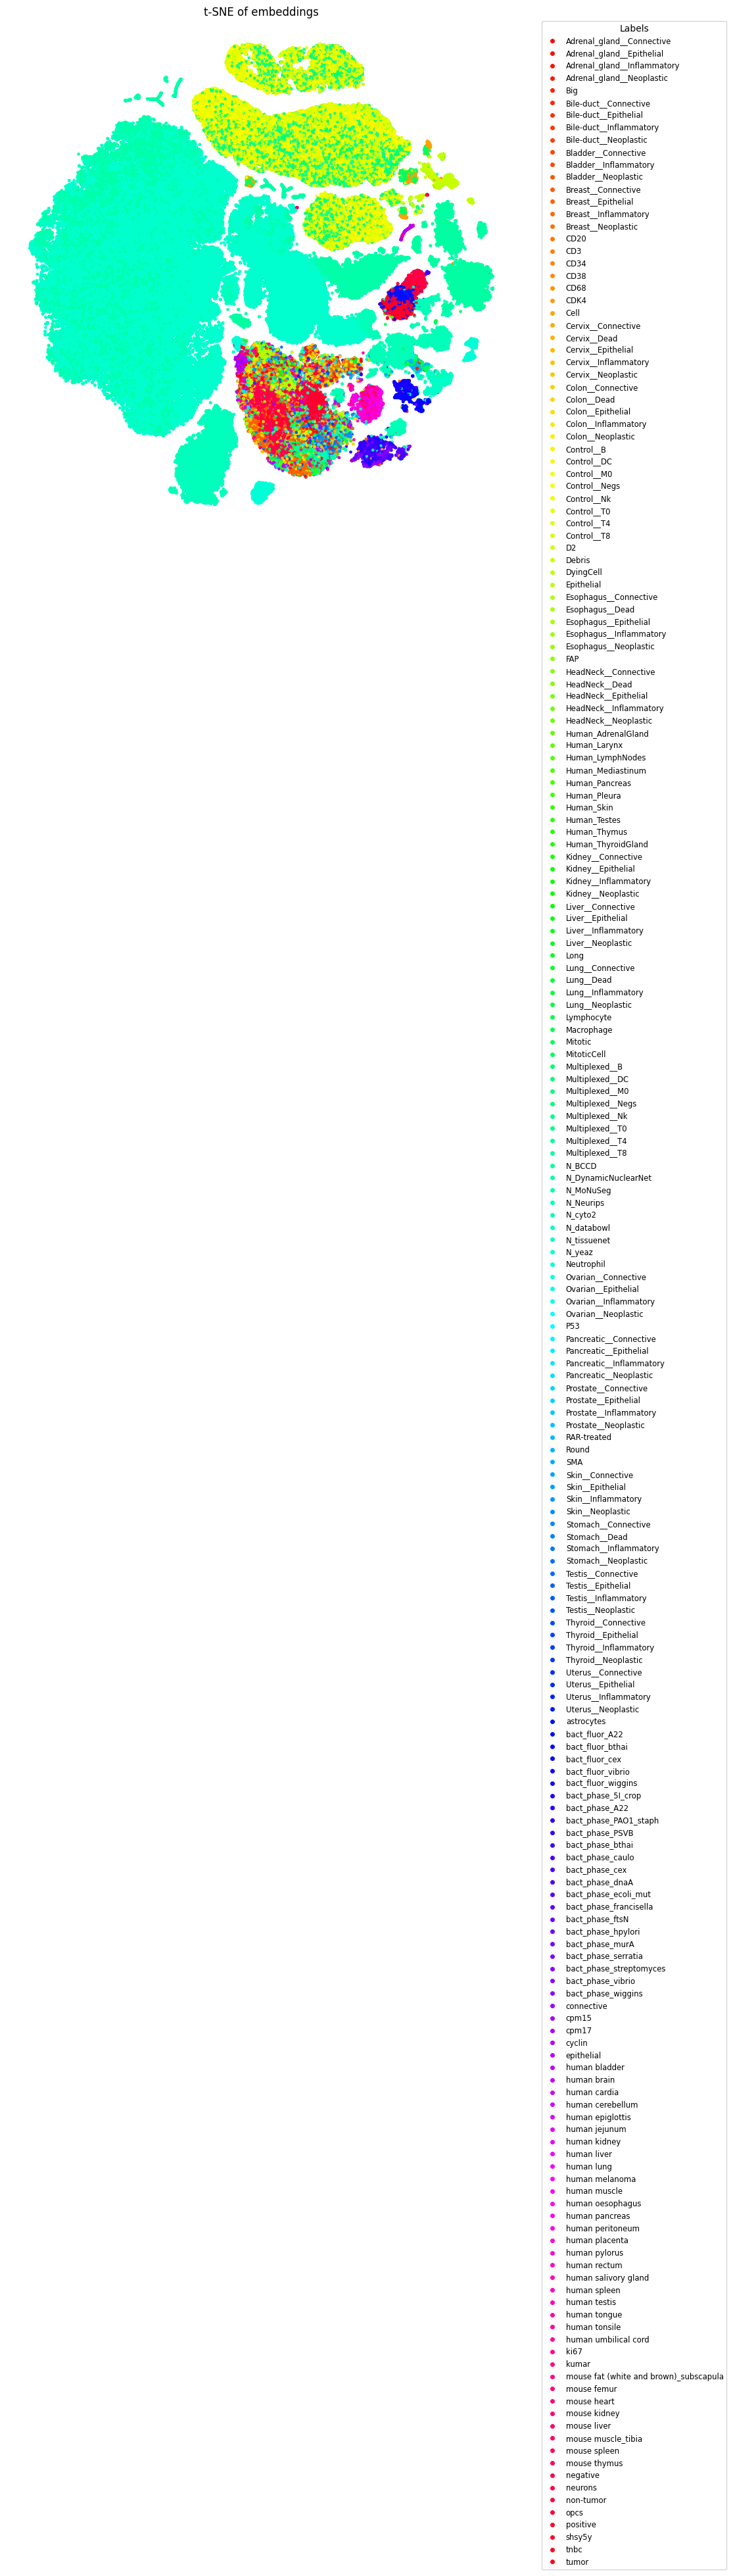

In [8]:
from dinov3.eval.tSNE import compute_tsne_and_plot

compute_tsne_and_plot(embeddings, labels, out_path="tsne_test_split.png", pca_dim=50,max_legend=220)

In [6]:
from dinov3.eval.simpleKNN import evaluate_simple_knn
import numpy as np

# Choose evaluation size:
EVAL_SIZE = embeddings.shape[0]
# sample without replacement
rng = np.random.default_rng(0)

N = embeddings.shape[0]
if EVAL_SIZE < N:
    idx = rng.choice(N, size=EVAL_SIZE, replace=False)
    emb_sample = embeddings[idx]
    lab_sample = [labels[i] for i in idx]
else:
    emb_sample = embeddings
    lab_sample = labels

In [9]:
results = evaluate_knn_faiss(
    emb_sample,
    lab_sample,
    k_list=[1, 3, 5],     # which k's you want
    metric="cosine",      # or "euclidean"
    sample_size=None,     # or e.g. 10000 if you want a random subset
    use_gpu=True,         # set False if you don’t have GPU
    exact=True            # True = exact nearest neighbors, False = IVF ANN
)

In [10]:
print("SKLEARN RESULTS:", results)

SKLEARN RESULTS: {1: {'topk_acc': 0.6425778027702969, 'precision@k': 0.6425778027702969, 'recall@k': 0.00013298517281967541, 'mAP': 0.7046682178552442}, 3: {'topk_acc': 0.792183589674475, 'precision@k': 0.6340057302062735, 'recall@k': 0.0003755079185496666, 'mAP': 0.7046682178552442}, 5: {'topk_acc': 0.8440668198749393, 'precision@k': 0.6286872808474941, 'recall@k': 0.0006034479616464858, 'mAP': 0.7046682178552442}}


In [ ]:
SKLEARN RESULTS: 
    1: topk_acc: 0.6425, precision@k: 0.6425, recall@k: 0.00013, mAP: 0.7046, 
    3: topk_acc: 0.7921, precision@k: 0.63400, recall@k: 0.00037, mAP: 0.7046,
    5: topk_acc: 0.8440, precision@k: 0.62868, recall@k: 0.00060, mAP: 0.7046

In [14]:



results = evaluate_simple_knn(emb_sample, lab_sample, k_list=[1,3], metric='cosine', sample_size=None)
print("SKLEARN RESULTS:", results)


KeyboardInterrupt: 

In [9]:
from dinov3.eval.simpleKNN import evaluate_simple_knn
import numpy as np

# Choose evaluation size:
EVAL_SIZE = embeddings.shape[0]
# sample without replacement
rng = np.random.default_rng(0)
N = embeddings.shape[0]
if EVAL_SIZE < N:
    idx = rng.choice(N, size=EVAL_SIZE, replace=False)
    emb_sample = embeddings[idx]
    lab_sample = [labels[i] for i in idx]
else:
    emb_sample = embeddings
    lab_sample = labels

results = evaluate_simple_knn(emb_sample, lab_sample, k_list=[1,5,10], metric='cosine', sample_size=None)
print("SKLEARN RESULTS:", results)


SKLEARN RESULTS: {1: {'top1_acc': np.float64(0.6429681817864952), 'precision@k': 0.6429681817864952, 'recall@k': 0.00013378630215555982, 'mAP': 0.6912077753996924}, 5: {'top1_acc': np.float64(0.6429681817864952), 'precision@k': 0.6282671586681571, 'recall@k': 0.0006105530371391535, 'mAP': 0.6912077753996924}, 10: {'top1_acc': np.float64(0.6429681817864952), 'precision@k': 0.6203020325269374, 'recall@k': 0.0011497153505180208, 'mAP': 0.6912077753996924}}


In [10]:
# Note for 50k samples
import json
print(json.dumps(results, sort_keys=True, indent=4))

{
    "1": {
        "mAP": 0.6912077753996924,
        "precision@k": 0.6429681817864952,
        "recall@k": 0.00013378630215555982,
        "top1_acc": 0.6429681817864952
    },
    "5": {
        "mAP": 0.6912077753996924,
        "precision@k": 0.6282671586681571,
        "recall@k": 0.0006105530371391535,
        "top1_acc": 0.6429681817864952
    },
    "10": {
        "mAP": 0.6912077753996924,
        "precision@k": 0.6203020325269374,
        "recall@k": 0.0011497153505180208,
        "top1_acc": 0.6429681817864952
    }
}


In [11]:
# Note for 430351 (20% of dataset) samples
import json
print(json.dumps(results, sort_keys=True, indent=4))

{
    "1": {
        "mAP": 0.6912077753996924,
        "precision@k": 0.6429681817864952,
        "recall@k": 0.00013378630215555982,
        "top1_acc": 0.6429681817864952
    },
    "5": {
        "mAP": 0.6912077753996924,
        "precision@k": 0.6282671586681571,
        "recall@k": 0.0006105530371391535,
        "top1_acc": 0.6429681817864952
    },
    "10": {
        "mAP": 0.6912077753996924,
        "precision@k": 0.6203020325269374,
        "recall@k": 0.0011497153505180208,
        "top1_acc": 0.6429681817864952
    }
}


In [ ]:
#db scan at end of epoch in three different hierachies
# positive and negative samples
# triplet loss